# Exercises for the course "Declarative Problem Solving Paradigms in AI"

In [1]:
# !pip install cpmpy numpy pychoco gurobipy networkx colorama tqdm hyperopt --quiet

import cpmpy as cp
import numpy as np

You can ignore google* and tensor* dependency errors.

## **Session 5 A: Solving technologies and encodings**

Welcome to the fifth exercise session of Declarative Problem Solving Paradigms in AI. In this session, we'll have a deeper look at the component of a model+solve system that we've somewhat been ignoring untill now; **the solver**.

Modeling-systems like CPMpy allow you to work in a high-level Constraint Programming language whilst being able to interchange the target solving backend in a transparant manner. There is no need (from a purely functional point of view) to be aware of how this backend functions, what lower-level language it accepts, for what types of problems it was originally designed, etc. The solver acts as a black box.

But now a counter-argument to this idealistic model+solve vision:
As a good modeler, and also from the lectures, you should understand that having some knowledge of the internal workings will allow you to make better "model-solver" combinations. How you formulate a model (e.g. integer vs boolean decision variables, global constraints, etc) will have an impact on the solver's performance depending on its particular technology. And choosing the right solver for the problem at hand (e.g. a technology that is very good at solving scheduling problems) can result in significant speed improvements.

The fifth session has been split up into two parts, each corresponding to a particular lecture. This notebook constitutes part A.

- **A**: Chapter 6: Solving technologies and encodings
- **B**: Chapter 7: CP search strategies and algorithm configuration


As seen in the lectures, a high-level modeling language the likes of CPMpy will support many solving backends (OR-Tools, Choco, Exact, Gurobi, ...) which are based on various solving technologies (CP, SAT, Pseudo-Boolean, ILP, ...). CPMpy utilises a "waterfall"-like transformation architecture as to stepwise translate a high-level model into the lower-level input language of one such technology.

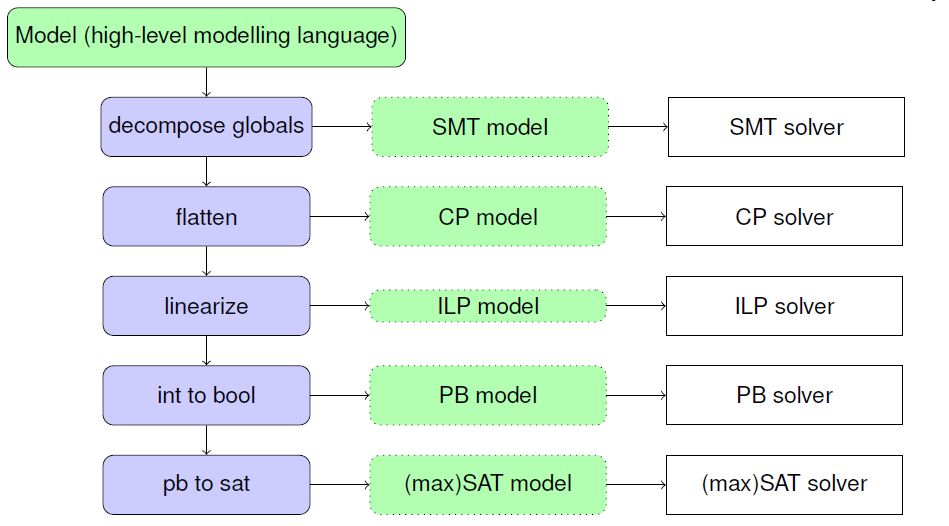



In part A, you'll experiment with some of these technologies, some low-level input languages, and the transformations that connect the two.


**Useful Resources:**
* CPMpy documentation: https://cpmpy.readthedocs.io/en/latest/index.html
* CPMpy quickstart: https://cpmpy.readthedocs.io/en/latest/modeling.html
* List of supported solvers / solving technologies: https://cpmpy.readthedocs.io/en/latest/#supported-solvers
* Documentation on hyperparameter configuration: https://cpmpy.readthedocs.io/en/latest/modeling.html#hyperparameter-search-across-different-parameters

### **Part 1: Problem-aware Decompositions**

#### **0. Setup**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_schedule(start, durations, t_max, capacity):
    """
    Creates a Gantt-chart visualization of a provided schedule.
    Gives colored feedback whether the schedule is feasible or not.

    Input:
    - start: A collection of start times, one for each event / job / ...
    - duration: The duration of the event / job / ...
    - t_max: The size of the scheduling window, i.e. all events should be scheduled within the interval [0..t_max]
    - capacity: The maximum number of events that can be scheduled in parallel
    """
    nr_tasks = len(start)

    # Plot Gantt chart
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot background grid first
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey', zorder=0)

    exceeds_limit = any(start[i] + durations[i] > t_max for i in range(nr_tasks))


    active_bars = np.zeros(shape=(t_max + 1))
    for i in range(nr_tasks):
        for t in range(start[i], start[i] + durations[i]):
            active_bars[t] += 1

    for i in range(nr_tasks):
        if start[i] + durations[i] > t_max:
            ax.broken_barh([(start[i], durations[i])], (i - 0.4, 0.8),
                           facecolors='tab:red', zorder=10)
        elif any(active_bars[t] > capacity for t in range(start[i], start[i] + durations[i])):
            ax.broken_barh([(start[i], durations[i])], (i - 0.4, 0.8),
                           facecolors='tab:orange', zorder=10)
        else:
            ax.broken_barh([(start[i], durations[i])], (i - 0.4, 0.8),
                           facecolors='tab:blue', zorder=10)

    if exceeds_limit or any(active_bars > 0):
        # Create a legend
        blue_patch = plt.Line2D([], [], color='tab:blue', linewidth=10, label='OK')
        red_patch = plt.Line2D([], [], color='tab:red', linewidth=10, label='Exceeds t_max')
        orange_patch = plt.Line2D([], [], color='tab:orange', linewidth=10, label='Exceeds capacity')
        plt.legend(handles=[blue_patch, red_patch, orange_patch], loc='upper right')

    # Color the background in regions where capacity has been exceeded
    for t in range(t_max + 1):
        if active_bars[t] > capacity:
            ax.axvspan(t, t + 1, color='tab:orange', alpha=0.3, zorder=0)

    # Add a dotted vertical line at t_max
    ax.axvline(x=t_max, color='black', linestyle='--', zorder=5)

    # Labeling and formatting
    ax.set_ylim(-1, nr_tasks)
    ax.set_xlim(0, max(t_max, max(start+durations)) + t_max//5)
    ax.set_xlabel("Time")
    ax.set_ylabel("Tasks")
    ax.set_yticks(range(nr_tasks))
    ax.set_yticklabels([f"{i+1}" for i in range(nr_tasks)])
    ax.set_title("Gantt Chart for Scheduled Tasks")

    plt.show()

def solvetime_table(models, problems):
    res = [] # to collect the results

    # Go over each problem instance, run each model against it, and collect the runtimes
    for i, problem in enumerate(problems):
        problem_res = {}
        for model_constructor in models:
            model, _ = model_constructor(problem["durations"], problem["t_max"], problem["capacity"])
            model.solve(time_limit=10) # 10s hard time limit
            problem_res[str(model_constructor.__name__)] = model.status().runtime
        res.append(problem_res)

    # Create a nice table
    df = pd.DataFrame(res)
    df.index = [f"Instance {i}" for i in range(len(problems))]
    df = df.T.style.set_caption("Table: Model solve time")
    return df

def plot_schedule_solution(model_constructor, problem):
    # Create the model
    model, start = model_constructor(problem["durations"], problem["t_max"], problem["capacity"])
    # Solve the model & visualize the result
    if model.solve():
        plot_schedule(start.value(), problem["durations"], problem["t_max"], problem["capacity"])
    else:
        print("No solution found.")

#### **1: Time-Resource decomposition**

Imagine the following scheduling problem:

Given a collection of tasks $X = \{x_0, x_1, ..., x_n\}$ each with different durations $D = \{d_0, d_1, ..., d_n\}$, a scheduling window $\left[0..t_{max}\right]$ and a capacity limit $C_{task}$ on the number of tasks that can be performed in parallel, schedule the task start times $S = \{s_0, s_1, ..., s_n\}$ whilst minimizing the completion time of all tasks: $\underset{S \in [0..t_{max}]^n}{\min}\underset{x_i \in X}{\max} \left(x_i + d_i\right)$.


In [3]:
problems = [
    # 0: A first example problem
    { "nr_tasks": 5, "capacity": 2, "t_max": 40, "durations": np.array([7, 5, 20, 20, 15]) },
    # 1: A problem with a larger scheduling window (t_max)
    { "nr_tasks": 5, "capacity": 2, "t_max": 200, "durations": np.array([38, 24, 30, 34, 15]) },
    # 2: A problem with a lot more tasks (nr_tasks)
    { "nr_tasks": 13, "capacity": 4, "t_max": 40, "durations": np.array([8, 3, 7, 2, 10, 8, 9, 1, 9, 6, 2, 10, 5]) },
]


This problem is ideal for the `Cumulative` global constraint. See an example model below:

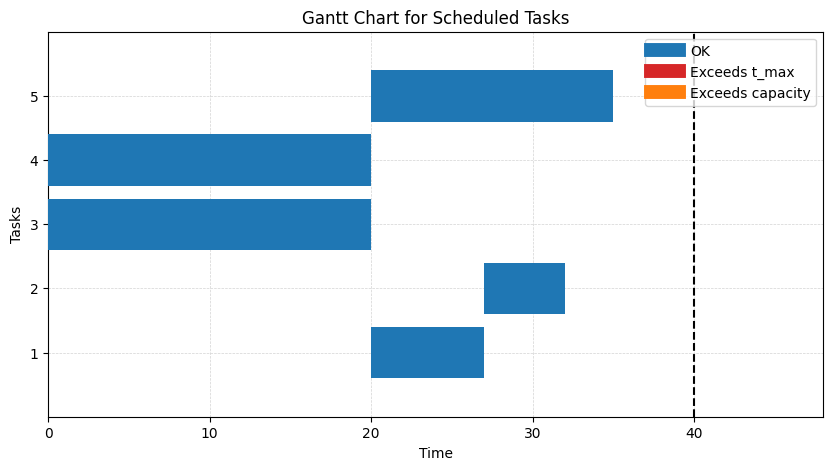

,Instance 0,Instance 1,Instance 2
scheduling_model_global,0.002584,0.002800,0.003754


In [4]:
def scheduling_model_global(durations, t_max, capacity):
    """
    A basic scheduling model using the "Cumulative" global constraint.
    """
    # Parameters of the Problem
    nr_tasks = len(durations)

    # Decision Variables
    start = cp.intvar(0, t_max, shape=nr_tasks) # the start of each scheduled task

    # Model
    model = cp.Model()

    # Constraints
    # 1) Cumulative global constraint
    #    https://cpmpy.readthedocs.io/en/latest/api/expressions/globalconstraints.html#cpmpy.expressions.globalconstraints.Cumulative
    model += cp.Cumulative(start, durations, start+durations, 1, capacity)
    # 2) Tasks should stay within the time limit
    model += (start + durations <= t_max)

    # Objective
    #   keep the schedule as short as possible
    model.minimize(cp.max(start + durations))

    return model, start

# Visualize a solution (to check if model is correct)
plot_schedule_solution(scheduling_model_global, problems[0])

# Collect model performance against a set of problem instances
solvetime_table(
    [scheduling_model_global],  # the models to test (can add more models to this list as to compare them)
    problems                    # the problem instances to test on
  )

When the `Cumulative` global constraint is not supported by a solver, we (or CPMpy) will have to **decompose** it.


Write your own **Time-Resource** decomposition of the `Cumulative` global constraint (as seen in the lectures on slide 17) and compare its solve time efficiency against the above model. For the comparison, simply add your new model to the `solvetime_table`.


For this decomposition, introduce a boolean matrix `B` where `B[i,t]` represents whether task `i` is active at time point `t` with `i ∈ [0..nr_tasks-1]` and `t ∈ [0..t_max-1]`.

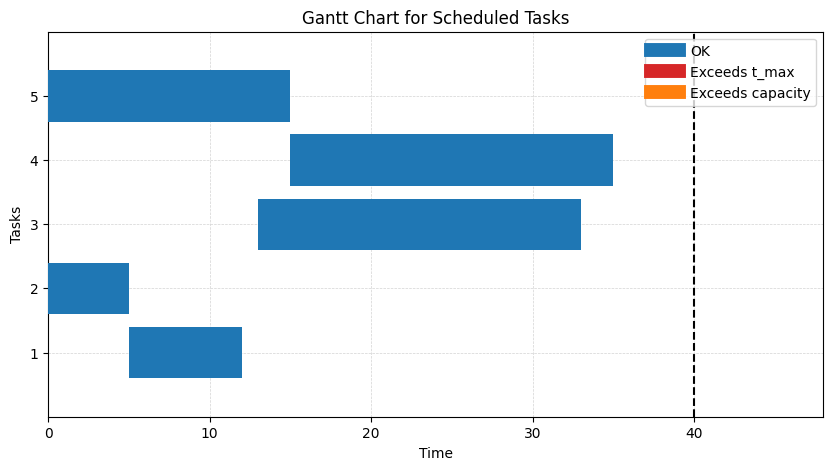

,Instance 0,Instance 1,Instance 2
scheduling_model_global,0.002510,0.002692,0.004934


In [5]:
def scheduling_model_time_resource(durations: np.ndarray, t_max: int, capacity: int):
    """A scheduling model using the time-resource decomposition."""

    # Parameters of the Problem
    nr_tasks = len(durations)

    # Decision Variables
    start = cp.intvar(0, t_max, shape=nr_tasks) # the start of each scheduled task

    # TODO: Create the new boolean matrix B needed for the time-resource decomposition.
    #      B[i,t] = True iff task i is active at time t
    B = cp.boolvar(shape=(nr_tasks, t_max))

    # Model
    model = cp.Model()

    # TODO: Fill in the missing constraints.
    for t in range(t_max):
        # 1) Definition of boolean matrix B
        #    B[i,t] = True iff task i is active at time t, i.e. its start must happen before or at t and its end must happen after t.
        model += B[:, t] == (start <= t) & ~(start <= t - durations)

    # 2) Tasks should stay within the time limit
    model += (start + durations <= t_max)

    # 3) The number of tasks at each time-point should respect the capacity
    for t in range(t_max):
        model += cp.sum(B[:, t]) <= capacity

    # Objective
    #   keep the schedule as short as possible
    model.minimize(cp.max(start + durations))

    return model, start

# Visualize a solution (to check if model is correct)
plot_schedule_solution(scheduling_model_time_resource, problems[0])

# TODO: Compare the solve-time efficiency
solvetime_table(
    [scheduling_model_global],  # the models to test (can add more models to this list as to compare them)
    problems                    # the problem instances to test on
  )

**Q**: Which model / representation is faster to solve? Why would that be?

The model with the global `Cumulative` constraint is faster across the board. This is to be expected, since global constraints are higher-level then their decomposed counterparts, making them more efficient due to better inference, better relaxation, stronger reasoning, stronger propagation, the ability to have specialized algorithms, etc. By decomposing, the solver completely loses the insight that the problem you're trying to solve is a scheduling problem.

#### **BONUS: Task-Resource decomposition**

Similarly to the previous exercise, re-write the scheduling model using a **Task-Resource** decomposition for the `Cumulative` global constraint (instead of time-resource).

Compare its solve time efficiency against the above two model. For the comparison, simply add your new model to the `solvetime_table`.

For this decomposition, introduce a matrix of boolean decision variables `B` where `B[i,j]` indicates whether task `i` and task `j` overlap, with task `i` starting earlier or at the same time as task `j`.

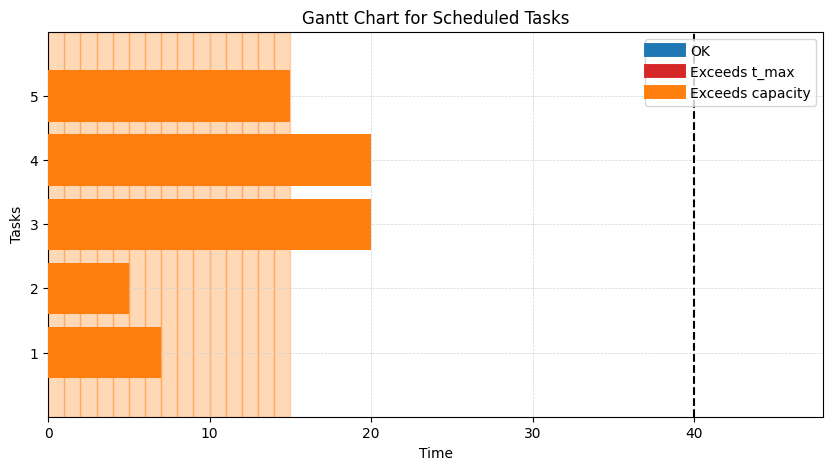

,Instance 0,Instance 1,Instance 2
scheduling_model_global,0.002528,0.003125,0.003910
scheduling_model_time_resource,0.014778,0.164010,0.200388
scheduling_model_task_resource,0.001938,0.002018,0.002007


In [6]:
def scheduling_model_task_resource(durations, t_max, capacity):
    """
    A scheduling model using the task-resource decomposition.
    """

    # Parameters of the Problem
    nr_tasks = len(durations)

    # Decision Variables
    start = cp.intvar(0, t_max, shape=nr_tasks) # the start of each scheduled task

    """
    TODO: Create the new boolean matrix B needed for the task-resource decomposition.
          B[i,j] = True iff task i and task j overlap,
          with i starting earlier or at the same time as j.
    """

    # Model
    model = cp.Model()

    # Constraints
    """
    TODO: Fill in the missing constraints.
    """
    # 1) Tasks should stay within the time limit
    # ┌────SOLUTION────┐
    model += (start + durations <= t_max)
    # └────────────────┘

    for i in range(nr_tasks):
        for j in range(nr_tasks):
            if i != j:
                # 2.1) Definition of boolean matrix B
                #      B[i,j] = True iff task i and task j overlap, with i starting earlier or at the same time as j
                #
                # task 1:  █████         B = [ 1 1 ]  task 1 overlaps with itself and with task 2
                # task 2:     ██████         [ 0 1 ]  task 2 overlaps with itself (not with task 1, due to not being EARLIER)
                #
                #          ┗━┻━┻━┻━┛
                #          0 1 2 3 4
                pass

            else:
                # 2.2) Definition of boolean matrix B
                #      Each task overlaps with itself
                pass

    # 3) Capacity limit

    # Objective
    #   keep the schedule as short as possible
    model.minimize(cp.max(start + durations))

    return model, start

# Visualize a solution (to check if model is correct)
plot_schedule_solution(scheduling_model_task_resource, problems[0])

"""
TODO: Compare the solve-time efficiency

HINT: Copy some code from above...
"""
# ┌────SOLUTION────┐
# Collect model performance against a set of problem instances
solvetime_table(
    [scheduling_model_global, scheduling_model_time_resource, scheduling_model_task_resource],  # the models to test
    problems                    # the problem instances to test on
  )
# └────────────────┘

**Q**: Which model / representation is now faster for which problem? Why would that be? Make the connection with the dimensions of the problem.

For the same reason as in the previous exercise, the model with the global constraint is (almost) always faster.

The **Time-Resource** decomposition creates a $nr\_tasks \times nr\_timesteps$ matrix. The number of boolean decision variables will scale linearly with the number or timesteps. Instance 1 has a large scheduling window, making the model harder to solve for this representation.

The **Task-Resource** decomposition creates a $nr\_tasks \times nr\_tasks$ matrix. Its number of boolean decision variables does not depend on the size of the scheduling window and is thus less affected by this increase in problem size. Problem instance 2 on the other hand tells a different story. The decomposition is now quadratically dependant on the number of tasks, compared to the linear dependancy of the previous decomposition. This also translates to the big difference in solve time.

### **Part 2. Solver-aware decomposition**

Besides adapting the decomposition to the problem instance at hand, one should also take the targeted solving technology into account. A chosen decomposition will result in a large collection of "conceptually simpler" constraints, but when not adapting to the technology and especially its input language, this could still result in a more difficult model to solve then when using a different decomposition.

#### **0. Setup**

In [7]:
from colorama import Fore, Style
"""Load helper function to check model solution."""

def check_unique_elements(lst):
    """Checks if all elements in a list are unique."""

    unique_elements = set(lst)
    if len(unique_elements) != len(lst):
        print("Not all elements are unique. The following elements are not unique:")
    for element in lst:
        if list(lst).count(element) > 1:
            print(Fore.RED + str(element) + Style.RESET_ALL, end=' ')
        else:
            print(Fore.GREEN + str(element) + Style.RESET_ALL, end=' ')
    print()

#### **1: AllDifferent: generic decomposition**


Examine the following model using the `AllDifferent` global constraint.

In [8]:
from cpmpy import SolverLookup

"""A simple model using the `AllDifferent` global constraint."""

# Decision Variables
x = cp.intvar(0, 50, shape=30)

# Model
model = cp.Model()

# Constraints
# 1) all x'es should be different
model += cp.AllDifferent(x)

# Solve
solver = SolverLookup().get("gurobi", model)
solver.solve()

# Show result
check_unique_elements(x.value())
print(solver.status())

Restricted license - for non-production use only - expires 2026-11-23
3 1 34 42 5 6 4 8 2 22 9 39 45 13 33 30 44 15 43 36 24 14 11 17 47 28 23 0 48 10 
ExitStatus.FEASIBLE (0.0018680095672607422 seconds)


Write a new model where you replace the `AllDifferent` constraint with a collection of decomposed pairwise `!=` constraints (lecture slide 17).



In [9]:
import itertools

# Decision Variables
x = cp.intvar(0, 50, shape=30)

# Model
model = cp.Model()

# Constraints
# 1) All elements of 'x' should be unique.
"""
TODO: Write down the != decomposition for `AllDifferent`

HINT: Use itertools.combinations(x, 2) to generate all pairwise combinations of elements of x.
"""
# ┌────SOLUTION────┐
for (a,b) in itertools.combinations(x, 2):
    model += a != b
# └────────────────┘

# Solve
solver = SolverLookup().get("gurobi", model)
solver.solve()

# Show result
check_unique_elements(x.value())
print(solver.status())

29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 0 
ExitStatus.FEASIBLE (0.016936063766479492 seconds)


**Q**: Compare the solve time against that of the above model. Why the difference in solve time? Why is the decomposition using "!=" not suitable for the chosen solver "Gurobi", an ILP solver.

As expected, the decomposed model is slower to solve. Not only due to no longer using a global constraint (which benefits from stronger reasoning), but also due to the use of `!=` constraints in combination with a ILP solver; Gurobi. ILP solvers require a linearization transformation on each expression before it can get posted to the solver. As seen in the lectures, for `!=` this will result in two big-M constraints, which is not ideal for performance-reasons.

#### **2. AllDifferent: Solver-aware decomposition**

Continuing on the previous exercise, create another model with an alternative decomposition for `AllDifferent` that does not use any `!=` but instead a matrix of binary auxiliary variables (as seen in the lectures slide 40).

In [10]:
# Decision Variables
x = cp.intvar(0, 50, shape=30)
# - auxiliary variables
lb, ub = min(a.lb for a in x), max(a.ub for a in x) # the bounds of the domain D (see lecture slides on linearization)

"""
TODO: Create matrix B of boolean decision variables.
      B is of shape n x m, where n is the number of variables 'x'
      and m the size of the domain D (the union of all domains of 'x').
      The boolean matrix will act as a one-hot encoding for all the values of 'x'.

HINT: To determine the size of a domain, calculate the distance between its upper and lower-bound.
"""
B = cp.boolvar(shape=(len(x), ub - lb + 1))

# Model
model = cp.Model()

# TODO: Constraints
# 1) Each variable can get one value (one-hot)
model += B.sum(axis=1) == 1
# 2) Each value is assigned to at most one variable (AllDifferent)
model += B.sum(axis=0) <= 1
# 3) Channeling constraints between 'B' and 'x'
for a, row in zip(x, B):
    model += a == cp.sum(np.arange(lb, ub + 1) * row)

# Solve
solver = SolverLookup().get("gurobi", model)
solver.solve()

# Show result
check_unique_elements(x.value())
print(solver.status())

3 1 34 42 5 6 4 8 2 22 9 39 45 13 33 30 44 15 43 36 24 14 11 17 47 28 23 0 48 10 
ExitStatus.FEASIBLE (0.0003159046173095703 seconds)


### **Part 3: Low-level modeling**

In the previous exercise session, when posting a CP-model to a specific solver / solving technology we've always relied on CPMpy to do the transformations for us. In this exercise, we'll try directly modeling in the lower-level language of a solver technology. More specificaly, creating a pseudo-boolean model.

#### **0. Setup**

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
from cpmpy.expressions.utils import flatlist
from typing import List
import re

cmap = plt.get_cmap('tab10').colors #["black", "yellow", "cyan", "lightgreen", "blue"]

def draw(g, **kwargs):
    nx.draw_circular(g, width=5, node_size=1500, **kwargs)
    plt.show()

def get_colors(color:List[int]):
    return [cmap[c] for c in color]

def show_graph(nodes, edges, colors=[], conflicts=[], satisfiable=[], corrections=[], **kwargs):
    """Visualizes a graph for the graph coloring problem."""

    # Create networkX graph
    G = nx.Graph()
    G.add_nodes_from(list(range(len(nodes))))
    G.add_edges_from([(a, b) for (a,b) in edges])
    nx_pos = nx.circular_layout(G)

    conflicts = flatlist(conflicts)
    satisfiable = flatlist(satisfiable)
    corrections = flatlist(corrections)

    conflict_edges = []
    for c in conflicts:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        conflict_edges.append((a, b))

    sat_edges = []
    for c in satisfiable:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        sat_edges.append((a, b))

    correction_edges = []
    for c in corrections:
        n1, n2 = c.args
        if n1.name == "max": continue
        a = int(re.search("\[[0-9]*\]", str(n1)).group()[1:-1])
        b = int(re.search("\[[0-9]*\]", str(n2)).group()[1:-1])
        correction_edges.append((a, b))

    # Create figure
    fig, ax = plt.subplots()
    nx.draw(G, nx_pos, with_labels=False, node_size=2000, node_color="white", font_size=20, font_color="black", ax=ax)
    nx.draw_networkx_labels(G, nx_pos)

    edge_colors = ["red" if (a, b) in conflict_edges else ("green" if (a,b) in sat_edges else ("orange" if (a,b) in correction_edges else "black")) for (a, b) in G.edges()]

    if len(colors) != 0:
        kwargs |= {"node_color": get_colors(colors)}

    # Draw edges
    nx.draw_networkx_edges(G, nx_pos, edgelist=G.edges(), edge_color=edge_colors, width=2, ax=ax)
    # Draw nodes
    draw(G, edge_color=edge_colors, **kwargs)

    plt.tight_layout()
    plt.show()

In [12]:
from cpmpy.expressions.utils import argvals
from cpmpy.transformations.flatten_model import flatlist
from cpmpy.expressions.variables import _BoolVarImpl, NegBoolView
from cpmpy import SolverLookup

def check_pb_variables(model):
    """Checks if all variables of a model are boolean variables."""
    solver = SolverLookup().get("ortools", model)
    invalid_counter = 0
    for var in solver.user_vars:
        if not isinstance(var, _BoolVarImpl):
            print(f"{invalid_counter} | Invalid PB model: {var} is not a boolean variable!")
            invalid_counter += 1
    return invalid_counter == 0

def check_pb_constraints(model):
    """Checks if all constraints of a model are valid pseudo-boolean constraints."""
    invalid_counter = 0
    for constraint in flatlist(model.constraints):
        if constraint.name == "==":
            if constraint.args[0].name == "sum":
                if all([isinstance(a, _BoolVarImpl) for a in constraint.args[0].args]):
                    pass
                else:
                    print(f"{invalid_counter} | Invalid PB model: {constraint} is not a valid PB constraint")
                    invalid_counter += 1
            else:
                print(f"{invalid_counter} | Invalid PB model: {constraint} is not a valid PB constraint")
                invalid_counter += 1
            if type(constraint.args[1]) == int:
                pass
            else:
                print(f"{invalid_counter} | Invalid PB model: {constraint} is not a valid PB constraint")
                invalid_counter += 1
        elif constraint.name == "or":
            if type(constraint.args[0]) == _BoolVarImpl or type(constraint.args[0]) == NegBoolView:
                pass
            else:
                print(f"{invalid_counter} | Invalid PB model: {constraint} is not a valid PB constraint")
                invalid_counter += 1
            if type(constraint.args[1]) == _BoolVarImpl or type(constraint.args[1]) == NegBoolView:
                pass
            else:
                print(f"{invalid_counter} | Invalid PB model: {constraint} is not a valid PB constraint")
                invalid_counter += 1

    return invalid_counter == 0

def check_pb_model(model):
    """Checks if a model is a valid pseudo-boolean model."""
    return check_pb_variables(model) and check_pb_constraints(model)

#### **1. PB Graph Coloring model**

Examine the following high-level model for the Graph Coloring problem:

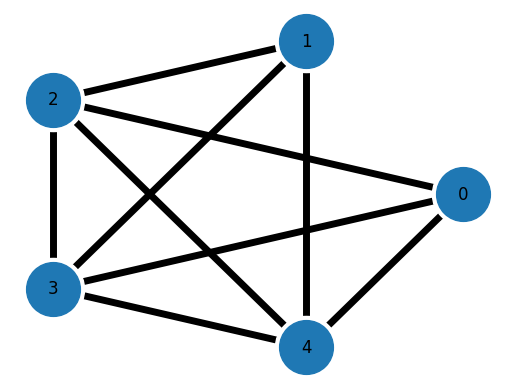

<Figure size 640x480 with 0 Axes>

In [13]:
# Problem instance
nodes = [0, 1, 2, 3, 4]
edges = [(nodes[i], nodes[j]) for i in range(len(nodes)) for j in range(i+1, len(nodes)) if (i,j) not in [(0,1)]] # fully connected, except between nodes 0 and 1

# Visualize the graph
show_graph(nodes, edges)

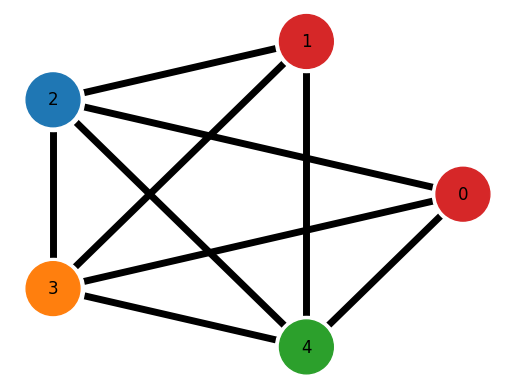

<Figure size 640x480 with 0 Axes>

In [14]:
# Parameters of the Problem
n = len(nodes)  # number of nodes
c = 4           # number of colors

# Decision Variables
x = cp.intvar(0, c-1, shape=n, name="x")  # for each node, one integer representing the assigned color

# Model
model = cp.Model()

# Constraints
for (i,j) in edges:
    # 1) neighbouring nodes (connected by an edge) cannot have the same color
    model += x[i] != x[j]

# Solve
if model.solve():
    show_graph(nodes, edges, colors=x.value())

Translate this model to a Pseudo-Boolean representation. This entails only using boolean decision variables and simple linear constraints, such as a sum, an "or", a negation, a linear inequality, ...

In [15]:
# Parameters of the Problem
n = len(nodes)  # number of nodes
c = 4           # number of colors

# Decision Variables
"""
TODO: Choose a set of decision variables that represent the color assignments across the nodes.
      Keep in mind that pseudo-boolean solving only works with boolean decision variables.
      Make use of the "direct encoding" for representing integers using booleans,
      as seen in the lectures slide 48.

      Direct encoding = one-hot encoding of integers.
      i.e.  for each integer decision variable
            |  for each possible value of said integer variable
            |  |  create a boolean decision variable indicating whether that value is assigned to the variable

      Or in the context of colors:
            for each node
            |  for each possible color
            |  |  create a boolean decision variable indicating whether that color is assigned to the node
"""
# ┌────SOLUTION────┐
# B[i,j] = 1 iff node i has color j
B = cp.boolvar(shape=(n,c), name="B")
# └────────────────┘

# Model
model = cp.Model()

# Constraints
# 1) Consistency constraints
"""
TODO: Your chosen set of boolean decision variables are a direct encoding of originally a set
      of integer decision variables. To make sure that the encoding functions as intended,
      since not all assignments to these boolean variables represent valid integers,
      add the required "Consistency Constraints".

      For example:
       - [0, 1, 0] is a valid direct encoding for the number 1,
       - [0, 1, 1] is not one-hot and does not represent any number at all
                   in our chosen encoding scheme
"""
# ┌────SOLUTION────┐
# Exactly 1 color must be assigned to each node, no more, no less.
for i in range(n):
    model += cp.sum(B[i, :]) == 1
# └────────────────┘


"""
TODO: Formulate, over your chosen set of decision variables,
      that neighbouring nodes cannot get the same color.

HINT: Node A and node B both not having color "red" can
      also be formulated as:
         "either node A does NOT have color 'red',
          or node B does NOT have color 'red'"
         ~ (color(A) = "red" | ~ (color(B) = "red")
"""
# ┌────SOLUTION────┐
for (i,j) in edges: # for each pair of neighbours
    for k in range(c): # for each color
        model += ~B[i,k] | ~B[j,k] # cannot both have that color at the same time
# └────────────────┘


# Check if the model you've created stays within the language of a pseudo-boolean solver
if check_pb_model(model):
    print("Model is Pseudo-Boolean")

# Solve the model
if model.solve():
    """
    TODO: Print the solution.
    """
    # ┌────SOLUTION────┐
    print("B:")
    print(B.value())
    # └────────────────┘
else:
    print("No valid configuration found.")

Model is Pseudo-Boolean
B:
[[False False  True False]
 [False False  True False]
 [False  True False False]
 [ True False False False]
 [False False False  True]]


If everything went correctly (no warning messages were shown), you've now created a Pseudo-Boolean model. Whether it is correct, i.e. it still represents the original Graph Coloring Problem, is a different question.

Fill in the below function that can check whether a given coloring (list of integers) is a solution to the original coloring problem.

MCS:
   (x[1]) != (x[2])
[0 1 1 2 3] is NOT a valid coloring of the graph


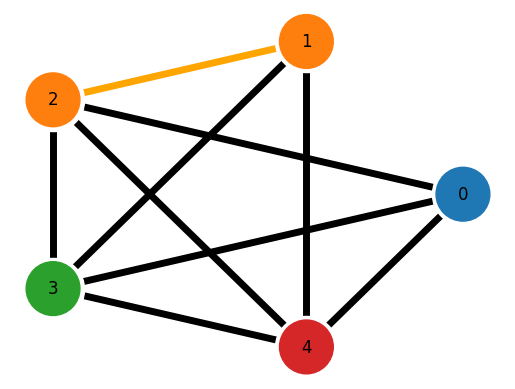

<Figure size 640x480 with 0 Axes>

[0 0 1 2 3] is a valid coloring of the graph


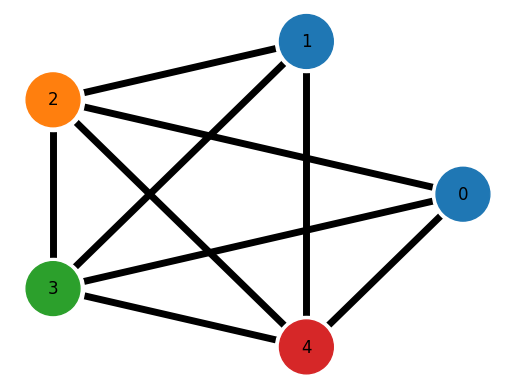

<Figure size 640x480 with 0 Axes>

In [16]:
from cpmpy.tools.explain.mcs import mcs

def check_solution(nodes, edges, colors):
    """
    Given a list of integers representing colors ('colors'),
    checks if it is a valid solution to the Graph Coloring problem of
    a graph with 'nodes' and 'edges'.

    (uses the original integer-based representation)
    """

    # Original CP-model
    x = cp.intvar(0, c-1, shape=n, name='x')
    model = cp.Model()
    for (i,j) in edges:
        model += x[i] != x[j]

    """
    TODO: To check if a set of values (in this case color assignments)
          is a valid solution to a model, we can enforce that solution
          through a collection of constraints and see if the model is
          still SAT.

          E.g. we have a set of values 'vals' and want to check if they
          formulate a solution to a model with as decision variables 'vars'.
          By adding 'vars == vals' to the model, solving it will either return
          SAT meaning that indeed 'vals' is a valid solution, or UNSAT meaning
          that 'vals' violates one or more constraints.
          -> we can then use MUS/MCS techniques to explain the UNSAT

          Now check the input 'colors' (argument of this function) against
          the above CP model to see if it is a valid solution.
    """
    # ┌────SOLUTION────┐
    model += x == colors
    # └────────────────┘

    sat = model.solve()

    if sat: # Is indeed a solution
        print(f"{colors} is a valid coloring of the graph")
        show_graph(nodes, edges, colors=x.value())
    else: # Is not a solution
        # We can use an MCS to explain the unsatisfiability
        MCS = mcs(model.constraints, hard=[x == colors])
        print("MCS:")
        for constraint in MCS:
            print("  ", constraint)
        print(f"{colors} is NOT a valid coloring of the graph")
        show_graph(nodes, edges, colors=x.value(), corrections=MCS)


# An example of a invalid solution
"""
TODO: Create an example of an invalid graph coloring solution.
"""
# colors = np.array([_, _, _, _, _])
# ┌────SOLUTION────┐
colors = np.array([0, 1, 1, 2, 3])
# └────────────────┘
check_solution(nodes, edges, colors)

# An example of a valid solution
"""
TODO: Create an example of an invalid graph coloring solution.
"""
# colors = np.array([_, _, _, _, _])
# ┌────SOLUTION────┐
colors = np.array([0, 0, 1, 2, 3])
# └────────────────┘
check_solution(nodes, edges, colors)

The above solution checker can only check models with the same integer decision variables as seen in the original CP graph coloring model. The earlier Pseudo-Boolean model uses a Direct Encoding of integers to boolean decision variables. As seen in the lectures (slide 48), we can easily convert them back.

\begin{equation}
  x = \sum_k k*b_{[x=k]}
\end{equation}

Complete the below code to go from the boolean decision variables back to integers through the direct encoding. You should now be able to check the solution coming from the pseudo-boolean model.

[2, 2, 1, 0, 3]
[2, 2, 1, 0, 3] is a valid coloring of the graph


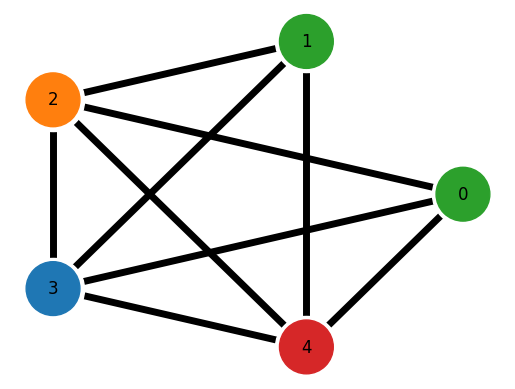

<Figure size 640x480 with 0 Axes>

In [17]:
"""
TODO: Write 'x', representing a set of integers, in terms of your
      proposed set of boolean variables based on their Direct Encoding.
"""

# x = [...f(i, B)... for i in range(n)]

# ┌────SOLUTION────┐
x = [
      sum([k * B[i,k].value() for k in range(c)])
      for i in range(n)
    ]
# └────────────────┘


# Print the solution in integer representation
print(x)

# Check our solution
check_solution(nodes, edges, x)

#### **2. BONUS**

At last, a small **bonus** thought exercise. To ensure that our pseudo-boolean direct encoding matches our original integer model, we've had to introduce "Consistency Constraints";

\begin{equation}
\sum_{k\in\{1..n\}} b_{[x=k]} = 1
\end{equation}

This translates to an "exactly one" constraint, i.e. each node must have exactly one color. This can be split into an "at least one" and an "at most one" constraint;

\begin{equation}
\sum_{k\in\{1..n\}} b_{[x=k]} <= 1
\end{equation}

\begin{equation}
\sum_{k\in\{1..n\}} b_{[x=k]} >= 1
\end{equation}

What happens if we drop the "at most one" constraint. Our boolean model will no longer be a direct encoding of the original integer model and our solutions will no longer match the original expected solution encoding. Despite these changes, what we get are still solutions to a graph coloring problem. We haven't changed anything about the "cannot give neighbours the same color" constraints. The new solutions are actually even "richer" than the original ones. Try to interpret what is so special about the new solutions that we'll get.


**Solution**

Removing the "at most one" constraint results in the possibility of nodes having multiple colors (something that was not possible with the original direct encoding). This is not a real issue, since all our graph coloring constraints are left untouched and the model thus still functions as expected. The solution we get is actually even richer. If we have a graph where each node gets assigned a single colore except for one node A with two colors (e.g. "red" and "blue"), what this solution encodes is actually two solutions of the original problem; one where node A gets color "red" and one where it gets color "blue". Our new pseudo-boolean encoding has the characteristic of being able to encode multiple solutions at once, allowing us to find mutliple solutions with just a single solve call. Trying to replicate this behaviour with our higher-level CP model would have made the model very complex, whilst here we get it almost for free due to a peculiarity of the chosen low-level encoding.